# Imports
All problem-speciffic files (code) in in the folder `MeshpLaplace2D`, namely the loading of pre-prepared mesh and definition of energy in jax.numpy.

In [5]:
from pLaplace2D.mesh import MeshpLaplace2D
import numpy as np
from mpi4py import MPI
import dolfinx
import ufl
import basix.ufl
from dolfinx import fem, mesh
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType  # type: ignore
from dolfinx.fem.petsc import apply_lifting, assemble_matrix, assemble_vector, set_bc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

mesh_level = 8
mesh_plaplace2d = MeshpLaplace2D(mesh_level=mesh_level)
triangles = mesh_plaplace2d.params["elems"]
points = mesh_plaplace2d.params["nodes"]

# Number of spatial dimensions (2 for 2D, 3 for 3D)
c_el = ufl.Mesh(basix.ufl.element("Lagrange", "triangle", 1, shape=(2,)))
# Create DOLFINx mesh
msh = dolfinx.mesh.create_mesh(MPI.COMM_WORLD, triangles, points, c_el)
# Define a continuous Galerkin (CG) function space of degree 1
V = fem.functionspace(msh, ("Lagrange", 1))
# --- Define Boundary Conditions ---
msh.topology.create_connectivity(1, 2)
boundary_facets = mesh.exterior_facet_indices(msh.topology)
dofs = fem.locate_dofs_topological(V, 1, boundary_facets)
# Define the Dirichlet boundary condition (u = 0 on non-free nodes)
bc = fem.dirichletbc(ScalarType(0), dofs, V)

# --- Define Variational Problem ---
# Define trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
# Define the forcing term as a constant
f_val = 1.0
f = fem.Constant(msh, ScalarType(f_val))
# Define the weak form of the Poisson equation
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx  # type: ignore

# --- Assemble System ---

# Create forms
a_form = fem.form(a)
L_form = fem.form(L)

In [6]:
# Assemble the matrix and vector
A = assemble_matrix(a_form, bcs=[bc])
A.assemble()

b = assemble_vector(L_form)
apply_lifting(b, [a_form], bcs=[[bc]])  # type: ignore
b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)  # type: ignore
set_bc(b, [bc])
b.assemble()

In [7]:
# --- Solve the System ---
# Create a Function to hold the solution
u_sol = fem.Function(V)

# Set up the PETSc solver
solver = PETSc.KSP().create(MPI.COMM_WORLD)  # type: ignore
solver.setOperators(A)
solver.setType("cg")  # Conjugate Gradient
solver.getPC().setType("lu")  # Incomplete LU preconditioner
solver.setFromOptions()

# Solve the linear system
solver.solve(b, u_sol.vector)  # type: ignore
u_sol.x.scatter_forward()  # type: ignore

u_sol_array = u_sol.x.array  # type: ignore

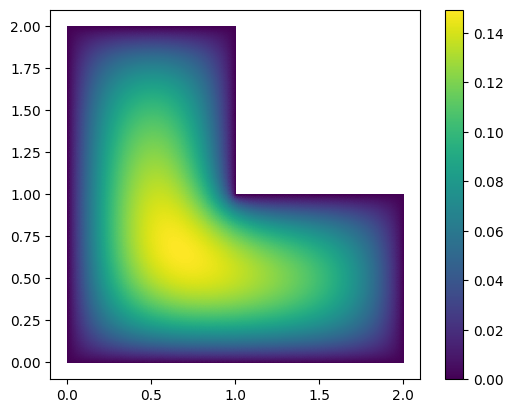

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.tripcolor(msh.geometry.x[:, 0], msh.geometry.x[:, 1], msh.geometry.dofmap, u_sol_array, shading='flat')
# add colorbar
plt.colorbar(ax.tripcolor(msh.geometry.x[:, 0], msh.geometry.x[:, 1], msh.geometry.dofmap, u_sol_array, shading='flat'))
plt.show()